In [47]:
import json
import pandas as pd 

df = pd.read_csv('/Users/marynelson/Downloads/dataset_website-content-crawler_2024-07-01_01-50-04-685.csv')

# print(df1.shape)

# Concatenate DataFrames
# df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
df.head()
print(df.shape)


/var/folders/mz/h1ch8y0s59vcljmdn1ygyf1c0000gn/T/ipykernel_85532/4042284176.py:4: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,23,24,25,27,28,29,30,32,33,34,35,37,38,39,40,41,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,67,68,69,70,72,73,74,76,77,78,79,80,82,83,84,85,86,88,89,90,91,92,93,94,95,96,97,98,99,100,101,103,105,106,107,108,109,110,111,112,113,114,116,118,119,120,121,123,124,125,126,128,129,130,131,132,133,134,136,137,139,140,141,142,143,145,146,147,148,150,151,152,153,154,155,158,159,160,161,162,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,184,185,188,189,190,191,192,193,198,199,200,201,202,203,205,206,207,208,210,211,212,213,214,215,216,217,218,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,28

(137803, 1991)


In [17]:
from datetime import datetime
# Function to calculate time since modified date
def time_since_modified(modified_date_str):
    if not isinstance(modified_date_str, str):
        return None
    if isinstance(modified_date_str, str):
        try:
            modified_date = datetime.strptime(modified_date_str, "%Y-%m-%dT%H:%M:%S%z")
            current_date = datetime.now(modified_date.tzinfo)  # Ensure the same timezone
            time_difference = current_date - modified_date
            return time_difference.days
        except:
            return 0

# Apply function to the DataFrame
df['days_since_modified'] = df['metadata/jsonLd/0/@graph/0/dateModified'].apply(lambda x: time_since_modified(x))


print(df.shape)

(137803, 1992)


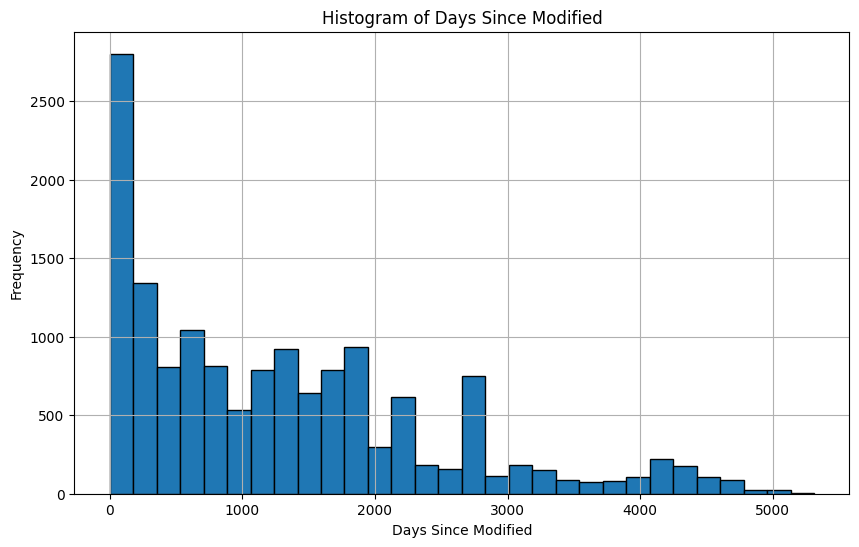

In [19]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['days_since_modified'], bins=30, edgecolor='black')
plt.title('Histogram of Days Since Modified')
plt.xlabel('Days Since Modified')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [21]:
import re
# Function to calculate content metrics
def calculate_content_metrics(markdown):
        # Replace URLs with a placeholder
    if not isinstance(markdown, str):
        return pd.Series([0, 0, 0, 0, 0, 0, 0, 0])
    
    url_placeholder = "URL_PLACEHOLDER"
    urls = re.findall(r'https?://[^\s]+', markdown)
    for url in urls:
        markdown = markdown.replace(url, url_placeholder)
        
    word_count = len(markdown.split())
    sentence_count = len(re.split(r'[.!?]+', markdown))
    char_count = len(markdown)
    average_word_length = sum(len(word) for word in markdown.split()) / word_count
    average_sentence_length = word_count / sentence_count if sentence_count else 0
    header_count = markdown.count('#')
    list_count = len(re.findall(r'^[*-]\s', markdown, re.MULTILINE))
    link_count = len(re.findall(r'\[.*?\]\(.*?\)', markdown))
    return pd.Series([word_count, sentence_count, char_count, average_word_length, average_sentence_length, header_count, list_count, link_count])
# Apply function to the DataFrame
df[['word_count', 'sentence_count', 'char_count', 'average_word_length', 'average_sentence_length', 'header_count', 'list_count', 'link_count']] = df['markdown'].apply(calculate_content_metrics)
print(df.shape)

(137803, 2000)


In [22]:
df = df.sort_values(by='days_since_modified', ascending=False)
print(len(df))

137803


In [23]:
def sentence_count_class(sc):
    if sc < 5:
        return 0
    elif sc < 20:
        return 1
    elif sc > 50:
        return 2
    else:
        return 0
    
df['sentence_count_class'] = df['sentence_count'].apply(sentence_count_class)


In [24]:
def age_class(age):
    if age < 365:
        return 2
    elif age < 720:
        return 1
    else:
        return 0
    
df['age_class'] = df['days_since_modified'].apply(age_class)

In [25]:
# Drop duplicates, keeping the first occurrence and removing subsequent duplicates
df= df.drop_duplicates(subset=['markdown'], keep='first')

# Display the DataFrame without duplicates
df.head()
print(df.shape)

(98078, 2002)


In [41]:
import tldextract
from urllib.parse import urlparse

def extract_parts(url):
    extracted = tldextract.extract(url)
    subdomain = extracted.subdomain if extracted.domain == "ucf" and extracted.suffix == "edu" else None

    # Extract the first path item
    parsed_url = urlparse(url)
    path_parts = parsed_url.path.strip('/').split('/')
    first_path_item = path_parts[0] if path_parts else None
    second_path_item = path_parts[1] if len(path_parts) > 1 else None
    link_depth = len(path_parts)
    
    return pd.Series([subdomain, first_path_item, second_path_item, link_depth])

# Apply function to the DataFrame
df[['subdomain', 'first_path_item', 'second_path_item', 'link_depth']] = df['metadata/canonicalUrl'].apply(lambda x: extract_parts(x))

# Display the updated DataFrame
df.head()
print(df.shape)

(98078, 2007)


In [27]:
def link_depth_class(link_depth):
    if link_depth < 2:
        return 2
    elif link_depth == 2:
        return 1
    elif link_depth> 2:
        return 0
    else:
        return 0
    
df['link_depth_class'] = df['link_depth'].apply(link_depth_class)

In [38]:
# List all columns
columns = df.columns.tolist()
print(columns)

['markdown', 'metadata/author', 'metadata/canonicalUrl', 'metadata/description', 'metadata/headers/accept', 'metadata/headers/accept-ch', 'metadata/headers/accept-language', 'metadata/headers/accept-ranges', 'metadata/headers/access-control-allow-credentials', 'metadata/headers/access-control-allow-headers', 'metadata/headers/access-control-allow-method', 'metadata/headers/access-control-allow-methods', 'metadata/headers/access-control-allow-origin', 'metadata/headers/access-control-max-age', 'metadata/headers/age', 'metadata/headers/akamai-grn', 'metadata/headers/alt-svc', 'metadata/headers/blazor-enhanced-nav', 'metadata/headers/cache-control', 'metadata/headers/cf-apo-via', 'metadata/headers/cf-cache-status', 'metadata/headers/cf-edge-cache', 'metadata/headers/cf-edge-cache-control', 'metadata/headers/cf-ray', 'metadata/headers/cf-wrk', 'metadata/headers/cneonction', 'metadata/headers/connection', 'metadata/headers/content-description', 'metadata/headers/content-disposition', 'metad

In [42]:
print(df[['metadata/canonicalUrl','subdomain','first_path_item','second_path_item','link_depth','link_depth_class']])

                                    metadata/canonicalUrl subdomain  \
50539   https://www.ucf.edu/news/what-if-the-big-ten-c...       www   
107411  https://www.ucf.edu/news/med-students-present-...       www   
20879   https://www.ucf.edu/news/ucf-in-top-10-at-robo...       www   
20812   https://www.ucf.edu/news/remembering-ucfs-firs...       www   
131687  https://www.ucf.edu/news/students-immersed-in-...       www   
...                                                   ...       ...   
137723  https://events.ucf.edu/calendar/2224/pre-healt...    events   
137725  https://events.ucf.edu/calendar/2224/pre-healt...    events   
137727  https://events.ucf.edu/calendar/2224/pre-healt...    events   
137729  https://events.ucf.edu/calendar/2224/pre-healt...    events   
137731  https://events.ucf.edu/calendar/2224/pre-healt...    events   

       first_path_item                           second_path_item  link_depth  \
50539             news     what-if-the-big-ten-conference-expands 

In [46]:
distinct_count = df.groupby(['subdomain'])['metadata/canonicalUrl'].nunique().reset_index()
sorted_df = distinct_count.sort_values(by='metadata/canonicalUrl', ascending=False)

print(sorted_df)


                      subdomain  metadata/canonicalUrl
18                       events                  63752
49                     sciences                  12115
53                          www                   9533
24                       guides                   6828
34                      library                   1853
6                      business                    663
39                      nursing                    513
44                      provost                    371
14                   compliance                    283
58                 www.research                    245
29                           it                    227
42                      physics                    201
46                    registrar                    167
30                         jobs                    156
22                       global                    151
52                         stem                    118
26                       honors                    112
27        

In [13]:
import tiktoken

def split_markdown_content(df, token_limit=5000, overlap_ratio=0.2):
    # Initialize the tokenizer
    enc = tiktoken.get_encoding('cl100k_base')  # Use the appropriate encoding

    def split_content(content):
        tokens = enc.encode(content)
        token_count = len(tokens)

        if token_count <= token_limit:
            return [content]

        chunk_size = int(token_limit * (1 - overlap_ratio))
        overlap_size = int(token_limit * overlap_ratio)
        chunks = []

        start = 0
        while start < token_count:
            end = start + token_limit
            chunk_tokens = tokens[start:end]
            chunk_text = enc.decode(chunk_tokens)
            chunks.append(chunk_text)
            start += chunk_size

        return chunks

    new_rows = []
    for _, row in df.iterrows():
        markdown_content = row['markdown']
        chunks = split_content(markdown_content)
        for chunk in chunks:
            new_row = row.copy()
            new_row['markdown'] = chunk
            new_rows.append(new_row)

    new_df = pd.DataFrame(new_rows)
    return new_df

df = split_markdown_content(df)
print(df.shape)

(56, 119)


In [14]:
# Exporting DataFrame to a CSV file
print(df.shape)
df.to_csv('itech_processed.csv', index=False)

(56, 119)
